In [23]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import pandas as pd
from scipy import stats
import time
import h5py
import ira_mod
sofi = ira_mod.SOFI()

def load_molecule_hdf5(filename, idx):
    """Load single molecule from HDF5 file"""
    with h5py.File(filename, 'r') as f:
        # Get coordinates and reshape
        coords_flat = f['coords'][idx]
        coords = coords_flat.reshape(-1, 3)
        
        # Get atom types (decode bytes to string)
        atom_types_str = f['atom_types'][idx]
        if isinstance(atom_types_str, bytes):
            atom_types_str = atom_types_str.decode('utf-8')
        atom_types = atom_types_str.split('|')
        
        # Get strings (decode bytes to string if necessary)
        smiles = f['smiles'][idx]
        if isinstance(smiles, bytes):
            smiles = smiles.decode('utf-8')
            
        selfies = f['selfies'][idx]
        if isinstance(selfies, bytes):
            selfies = selfies.decode('utf-8')
        
        return {
            'atom_types': atom_types,
            'coords': coords,
            'smiles': smiles,
            'selfies': selfies
        }

def analyze_sym_thr_range_streamlined(filename, test_indices, sym_thr_values):
    """
    Analyze multiple sym_thr values - tracking only essential metrics
    """
    results = []
    
    print(f"Testing {len(sym_thr_values)} threshold values on {len(test_indices)} molecules...")
    
    for i, idx in enumerate(test_indices):
        if (i+1) % 1000 == 0:
            print(f"Processing molecule {i+1}/{len(test_indices)} (index {idx})")
        
        # Load molecule
        mol = load_molecule_hdf5(filename, idx)
        atoms = mol["atom_types"]
        coords = np.array(mol["coords"], dtype=float)
        nat = len(atoms)
            
        # Create atom type mapping
        unique_atoms = list(set(atoms))
        atom_type_map = {atom: i+1 for i, atom in enumerate(sorted(unique_atoms))}
        typ = np.array([atom_type_map[atom] for atom in atoms], dtype=int)
        
        # Test different sym_thr values
        mol_results = {'molecule_idx': idx, 'n_atoms': nat, 'atom_types': len(unique_atoms)}
        
        for sym_thr in sym_thr_values:
            try:
                sym = sofi.compute(nat, typ, coords, sym_thr)
                
                # Check if linear and correct point group
                is_collinear, linear_axis = sofi.check_collinear(nat, coords)
                if is_collinear:
                    if sym.n_sym == 1:
                        pg = "C∞v"
                    else:
                        pg = "D∞h"
                else:
                    pg = sym.pg
                
                mol_results[f'pg_{sym_thr}'] = pg
                mol_results[f'failed_{sym_thr}'] = False
                
            except Exception as e:
                print(f"Error with molecule {idx} at sym_thr {sym_thr}: {e}")
                mol_results[f'pg_{sym_thr}'] = 'FAILED'
                mol_results[f'failed_{sym_thr}'] = True
        
        results.append(mol_results)
    
    return pd.DataFrame(results)

def analyze_streamlined_metrics(df, sym_thr_values):
    """
    Analyze only essential metrics: diversity, dominance, and failure rate
    """
    print("\n=== STREAMLINED ANALYSIS ===")
    
    metrics = {}
    
    for sym_thr in sym_thr_values:
        pg_col = f'pg_{sym_thr}'
        failed_col = f'failed_{sym_thr}'
        
        if pg_col in df.columns:
            # Filter out failed computations for point group analysis
            successful_pgs = df[df[failed_col] == False][pg_col]
            
            # 1. Point group diversity (number of unique point groups)
            pg_counts = successful_pgs.value_counts()
            metrics[f'pg_diversity_{sym_thr}'] = len(pg_counts)
            
            # 2. Dominance of most common point group
            if len(pg_counts) > 0:
                metrics[f'most_common_pg_{sym_thr}'] = pg_counts.index[0]
                metrics[f'dominance_{sym_thr}'] = pg_counts.iloc[0] / len(successful_pgs)
            else:
                metrics[f'most_common_pg_{sym_thr}'] = 'NONE'
                metrics[f'dominance_{sym_thr}'] = 0.0
            
            # 3. Failure rate
            failure_rate = df[failed_col].mean()
            metrics[f'failure_rate_{sym_thr}'] = failure_rate
            
            print(f"sym_thr={sym_thr:.3f}: {len(pg_counts)} unique PGs, "
                  f"dominance={metrics[f'dominance_{sym_thr}']:.1%}, "
                  f"failure rate={failure_rate:.1%}")
    
    return metrics

def plot_streamlined_results(df, sym_thr_values, metrics):
    """
    Create focused plots for the three key metrics
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    total_molecules = len(df)
    
    # Extract data for plotting
    diversities = []
    dominance_counts = []  # Absolute count instead of fraction
    failure_counts = []    # Absolute count instead of rate
    
    for thr in sym_thr_values:
        if f'pg_diversity_{thr}' in metrics:
            diversities.append(metrics[f'pg_diversity_{thr}'])
            # Convert fraction to absolute count
            dominance_counts.append(int(metrics[f'dominance_{thr}'] * total_molecules))
            failure_counts.append(int(metrics[f'failure_rate_{thr}'] * total_molecules))
    
    # 1. Point group diversity
    ax = axes[0]
    ax.plot(sym_thr_values[:len(diversities)], diversities, 'o-', color='blue', linewidth=2)
    ax.set_xlabel('sym_thr', fontsize=12)
    ax.set_ylabel('Number of Unique Point Groups', fontsize=12)
    ax.set_title('Point Group Diversity', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 2. Absolute count of most common point group
    ax = axes[1]
    ax.plot(sym_thr_values[:len(dominance_counts)], dominance_counts, 'o-', color='green', linewidth=2)
    ax.set_xlabel('sym_thr', fontsize=12)
    ax.set_ylabel('Count of Most Common PG', fontsize=12)
    ax.set_title('Most Common Point Group Count', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 3. Absolute count of failures
    ax = axes[2]
    ax.plot(sym_thr_values[:len(failure_counts)], failure_counts, 'o-', color='red', linewidth=2)
    ax.set_xlabel('sym_thr', fontsize=12)
    ax.set_ylabel('Number of Failures', fontsize=12)
    ax.set_title('Computation Failures Count', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def recommend_optimal_sym_thr_streamlined(df, sym_thr_values, metrics):
    """
    Provide recommendations based on streamlined metrics
    """
    print("\n=== STREAMLINED RECOMMENDATIONS ===")
    
    # Find threshold with good balance of diversity, reasonable dominance, and low failure rate
    scores = []
    
    for thr in sym_thr_values:
        diversity_key = f'pg_diversity_{thr}'
        dominance_key = f'dominance_{thr}'
        failure_key = f'failure_rate_{thr}'
        
        if all(key in metrics for key in [diversity_key, dominance_key, failure_key]):
            diversity = metrics[diversity_key]
            dominance = metrics[dominance_key]
            failure_rate = metrics[failure_key]
            
            # Score based on: high diversity, reasonable dominance (~0.3-0.7), low failure rate
            diversity_score = min(diversity / 20, 1.0)  # Normalize, cap at 20 unique PGs
            dominance_score = 1.0 - abs(dominance - 0.5)  # Penalize extreme dominance
            failure_score = 1.0 - failure_rate  # Lower failure rate is better
            
            # Weighted combination
            total_score = 0.4 * diversity_score + 0.3 * dominance_score + 0.3 * failure_score
            scores.append((thr, total_score, diversity, dominance, failure_rate))
    
    if scores:
        # Sort by total score
        scores.sort(key=lambda x: x[1], reverse=True)
        
        print("Top 3 candidates:")
        for i, (thr, score, div, dom, fail) in enumerate(scores[:3]):
            print(f"{i+1}. sym_thr = {thr:.3f} (score: {score:.3f})")
            print(f"   - Diversity: {div} unique PGs")
            print(f"   - Dominance: {dom:.1%}")
            print(f"   - Failure rate: {fail:.1%}")
            print()
        
        optimal_thr = scores[0][0]
        print(f"🎯 RECOMMENDED sym_thr: {optimal_thr:.3f}")
        return optimal_thr
    
    return None

def find_optimal_sym_thr_streamlined(filename, n_test_molecules=1000, 
                                   sym_thr_range=(0.8, 1.25), n_thresholds=10, seed=42):
    """
    Streamlined workflow to find optimal sym_thr
    """
    print("=== STREAMLINED sym_thr OPTIMIZATION ===")
    
    # Generate threshold values to test
    min_r, max_r = sym_thr_range
    sym_thr_values = np.linspace(min_r, max_r, n_thresholds)
    
    print(f"Testing thresholds: {[f'{t:.3f}' for t in sym_thr_values]}")
    
    # Select random test molecules
    with h5py.File(filename, 'r') as f:
        total_molecules = len(f['coords'])
    
    np.random.seed(seed)  # For reproducibility
    test_indices = np.random.choice(total_molecules, 
                                   size=min(n_test_molecules, total_molecules), 
                                   replace=False)
    
    print(f"Testing on {len(test_indices)} randomly selected molecules")
    
    # Run analysis
    start_time = time.time()
    df = analyze_sym_thr_range_streamlined(filename, test_indices, sym_thr_values)
    end_time = time.time()
    
    print(f"\nAnalysis completed in {end_time - start_time:.1f} seconds")
    
    # Analyze results
    metrics = analyze_streamlined_metrics(df, sym_thr_values)
    
    # Plot results
    plot_streamlined_results(df, sym_thr_values, metrics)
    
    # Get recommendation
    optimal_sym_thr = recommend_optimal_sym_thr_streamlined(df, sym_thr_values, metrics)
    
    # Save results
    df.to_csv('sym_thr_streamlined_results.csv', index=False)
    
    # Save summary metrics
    summary_df = pd.DataFrame([
        {
            'sym_thr': thr,
            'diversity': metrics.get(f'pg_diversity_{thr}', 0),
            'dominance_count': metrics.get(f'dominance_count_{thr}', 0),
            'dominance_fraction': metrics.get(f'dominance_fraction_{thr}', 0),
            'failure_count': metrics.get(f'failure_count_{thr}', 0),
            'failure_rate': metrics.get(f'failure_rate_{thr}', 1),
            'most_common_pg': metrics.get(f'most_common_pg_{thr}', 'UNKNOWN')
        }
        for thr in sym_thr_values
    ])
    summary_df.to_csv('sym_thr_summary.csv', index=False)
    
    print(f"\nResults saved to 'sym_thr_streamlined_results.csv' and 'sym_thr_summary.csv'")
    
    return optimal_sym_thr, df

=== STREAMLINED sym_thr OPTIMIZATION ===
Testing thresholds: ['0.800', '0.850', '0.900', '0.950', '1.000', '1.050', '1.100', '1.150', '1.200', '1.250']
Testing on 100000 randomly selected molecules
Testing 10 threshold values on 100000 molecules...
Processing molecule 1000/100000 (index 163855)
Processing molecule 2000/100000 (index 805141)
Error with molecule 629011 at sym_thr 1.25: nonzero error value obtained from libira_compute_all()
 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 ERROR: cannot set beta. Structure not properly shifted?
 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 small norm:   1.2500000000000000     
           3
 i=           3 j=           4
           3  0.40799995263417577      -0.48239998519420624       -7.7033335963884994E-002
           2  0.90280004342397069       0.79229997098445892       0.12646667410929996     
           1  -1.3107999960581460      -0.30989998579025269       -4.9433338145414993E-002
 origin at: /home/turih/IterativeRotationsAssignments/src/sof

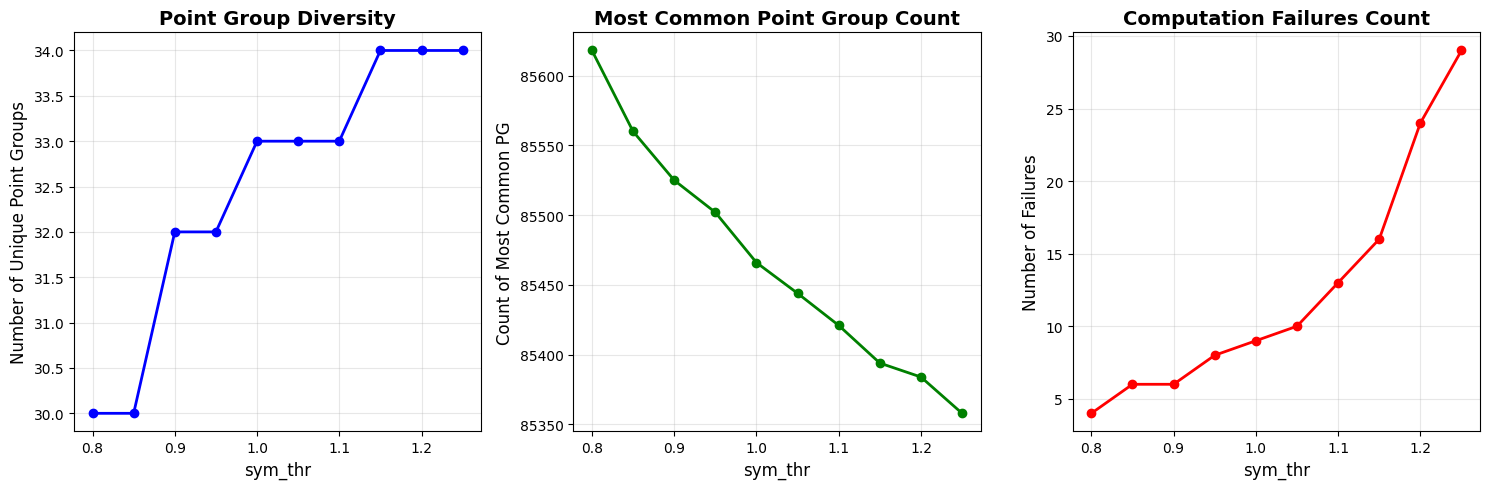


=== STREAMLINED RECOMMENDATIONS ===
Top 3 candidates:
1. sym_thr = 1.250 (score: 0.894)
   - Diversity: 34 unique PGs
   - Dominance: 85.4%
   - Failure rate: 0.0%

2. sym_thr = 1.200 (score: 0.894)
   - Diversity: 34 unique PGs
   - Dominance: 85.4%
   - Failure rate: 0.0%

3. sym_thr = 1.150 (score: 0.894)
   - Diversity: 34 unique PGs
   - Dominance: 85.4%
   - Failure rate: 0.0%

🎯 RECOMMENDED sym_thr: 1.250

Results saved to 'sym_thr_streamlined_results.csv' and 'sym_thr_summary.csv'


In [24]:
optimal_thr, results_df = find_optimal_sym_thr_streamlined("mol3d_data/molecules3d_million_1.h5", n_test_molecules=100000, seed=42)